In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e4/sample_submission.csv
/kaggle/input/playground-series-s3e4/train.csv
/kaggle/input/playground-series-s3e4/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 12
FOLDS = 5
STRATEGY = 'median'

In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s3e4/test.csv')
df_train = pd.read_csv('/kaggle/input/playground-series-s3e4/train.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s3e4/sample_submission.csv')

In [5]:
print('number of rows in train dataset ', df_train.shape[0])
print('number of column in train dataset', df_train.shape[1])
print('number of missing values in train dataset', sum(df_train.isna().sum()))

number of rows in train dataset  219129
number of column in train dataset 32
number of missing values in train dataset 0


In [6]:
df_train.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,...,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000
mean,109564.000000,62377.415376,0.096008,0.048345,0.592102,0.069273,-0.161555,0.133688,-0.128224,0.149534,...,-0.031064,-0.050852,-0.050531,-0.002992,0.124005,0.009881,0.014034,0.017313,66.359803,0.002140
std,63257.237906,25620.348569,1.395425,1.159805,1.132884,1.253125,1.069530,1.202411,0.817207,0.716212,...,0.422777,0.597812,0.318175,0.593100,0.406741,0.473867,0.233355,0.164859,150.795017,0.046214
min,0.000000,0.000000,-29.807725,-44.247914,-19.722872,-5.263650,-37.591259,-25.659750,-31.179799,-28.903442,...,-14.689621,-8.748979,-11.958588,-2.836285,-3.958591,-1.858672,-9.234767,-4.551680,0.000000,0.000000
25%,54782.000000,47933.000000,-0.846135,-0.573728,-0.027154,-0.769256,-0.847346,-0.631835,-0.646730,-0.095948,...,-0.190418,-0.473099,-0.174478,-0.332540,-0.126080,-0.318330,-0.050983,-0.009512,5.990000,0.000000
50%,109564.000000,63189.000000,0.385913,0.046937,0.735895,0.064856,-0.229929,-0.087778,-0.098970,0.111219,...,-0.042858,-0.032856,-0.063307,0.038708,0.145934,-0.086388,0.015905,0.022163,21.900000,0.000000
75%,164346.000000,77519.000000,1.190661,0.814145,1.306110,0.919353,0.356856,0.482388,0.385567,0.390976,...,0.109187,0.354910,0.060221,0.394566,0.402926,0.253869,0.076814,0.066987,68.930000,0.000000
max,219128.000000,120580.000000,2.430494,16.068473,6.145578,12.547997,34.581260,16.233967,39.824099,18.270586,...,22.062945,6.163541,12.734391,4.572739,3.111624,3.402344,13.123618,23.263746,7475.000000,1.000000


In [7]:
df_sample.head()

,id,Class
0,219129,0.5
1,219130,0.5
2,219131,0.5
3,219132,0.5
4,219133,0.5


In [8]:
df_train.drop(["id"] , axis = 1 , inplace = True)
df_test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'Class'
FEATURES = [col for col in df_train.columns if col != TARGET]
RANDOM_STATE = 12 

In [9]:
df_train.drop(columns = ["Time", "Amount"]).iloc[:, :-1].describe().T.sort_values(by='max' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
V7,219129.000000,-0.128224,0.817207,-31.179799,-0.646730,-0.098970,0.385567,39.824099
V5,219129.000000,-0.161555,1.069530,-37.591259,-0.847346,-0.229929,0.356856,34.581260
V28,219129.000000,0.017313,0.164859,-4.551680,-0.009512,0.022163,0.066987,23.263746
V21,219129.000000,-0.031064,0.422777,-14.689621,-0.190418,-0.042858,0.109187,22.062945
V8,219129.000000,0.149534,0.716212,-28.903442,-0.095948,0.111219,0.390976,18.270586
V6,219129.000000,0.133688,1.202411,-25.659750,-0.631835,-0.087778,0.482388,16.233967
V2,219129.000000,0.048345,1.159805,-44.247914,-0.573728,0.046937,0.814145,16.068473
V10,219129.000000,-0.039758,0.821889,-22.092656,-0.499563,-0.106034,0.403967,15.878405
V20,219129.000000,0.009708,0.439521,-18.679066,-0.167927,-0.037702,0.126750,15.407839
V9,219129.000000,-0.048337,1.054143,-8.756951,-0.711444,-0.131323,0.583715,13.423914


In [10]:
df = pd.concat([df_train[FEATURES], df_test[FEATURES]], axis=0)
cat_features = [col for col in FEATURES if df[col].nunique() < 25 ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 ]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')

Total number of features: 30
Number of categorical features: 0
Number of continuos features: 30


In [11]:
labels=['Categorical', 'Continuos']
values= [len(cat_features), len(cont_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, 
    marker=dict(colors=colors, 
               )
)])
fig.show()

In [12]:
train_amount = df_train.copy()
test_amount = df_test.copy()
train_amount["type"] = "Train"
test_amount["type"] = "Test"
amountdf = pd.concat([train_amount, test_amount])
amountdf = amountdf[amountdf["Amount"]<100]
fig = px.histogram(data_frame = amountdf, 
                   x="Amount",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Amount (< 100)" , title_x = 0.5)
fig.show()


In [13]:
target_df = pd.DataFrame(df_train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count'
            ) 
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / df_train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / df_train.shape[0]))
fig.show()

Percentage of Transported = 0: 99.79 %
Percentage of Transported = 1: 0.21 %


In [14]:
pd.options.display.max_columns = None
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [15]:
df_train['Class'].value_counts()

0    218660
1       469
Name: Class, dtype: int64

In [16]:
## droping Time column
FEATURES.remove("Time")
df_train.drop(["Time" ] , axis = 1 ,inplace = True)
df_test.drop(["Time"] , axis = 1 ,inplace = True)
X = df_train.drop(TARGET , axis =1 )
y = df_train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

In [17]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'device' : 'gpu',
}


lgb_predictions = 0
lgb_scores = []
lgb_fimp = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [18]:
for fold, (train_idx, valid_idx) in enumerate(skf.split(df_train[FEATURES], df_train[TARGET])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = df_train.iloc[train_idx][FEATURES], df_train.iloc[valid_idx][FEATURES]
    y_train , y_valid = df_train[TARGET].iloc[train_idx] , df_train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  preds_valid)
    lgb_scores.append(auc)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    test_preds = model.predict_proba(df_test[FEATURES])[:, 1]
    lgb_predictions += test_preds/FOLDS
    
print("Mean AUC :", np.mean(lgb_scores))

========== Fold=1 ==========
Fold=1, AUC score: 0.67, Run Time: 8.54s
========== Fold=2 ==========
Fold=2, AUC score: 0.61, Run Time: 3.60s
========== Fold=3 ==========
Fold=3, AUC score: 0.60, Run Time: 2.58s
========== Fold=4 ==========
Fold=4, AUC score: 0.63, Run Time: 2.79s
========== Fold=5 ==========
Fold=5, AUC score: 0.67, Run Time: 2.67s
Mean AUC : 0.6351022033331574


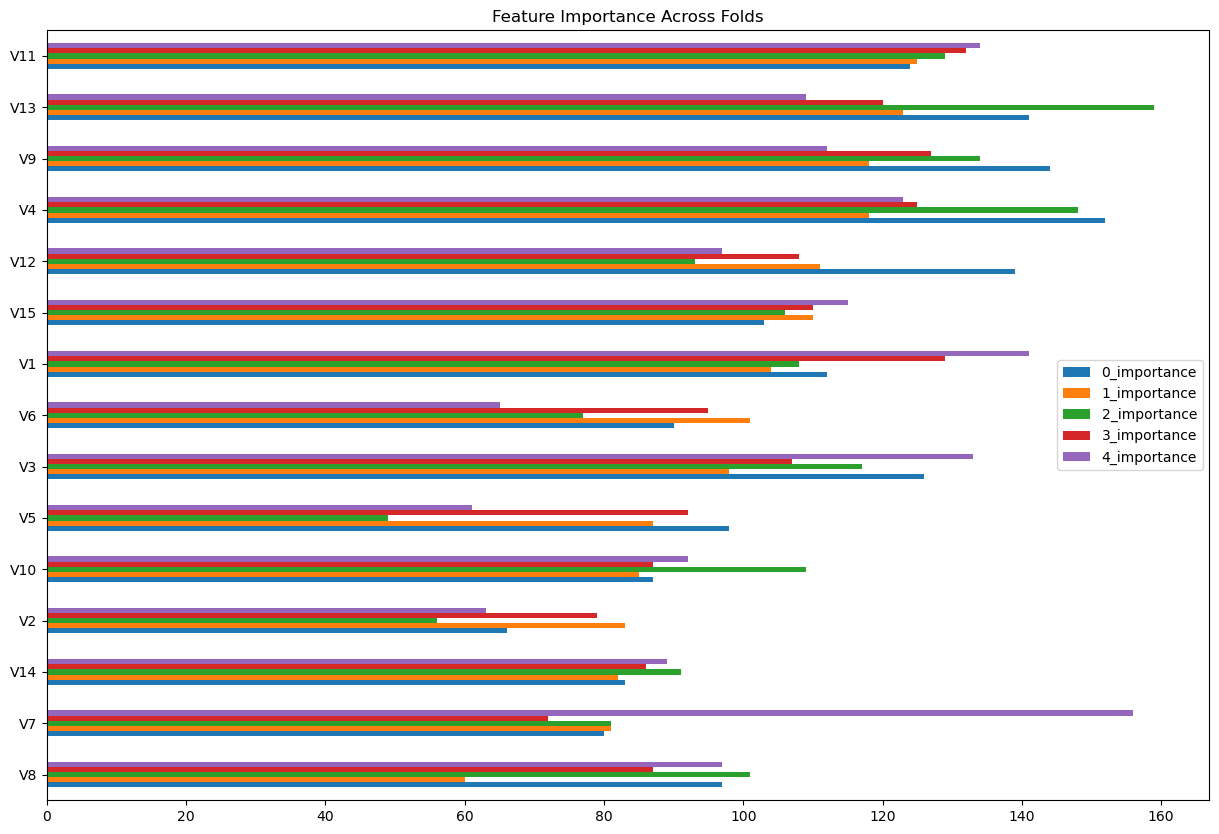

In [19]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

In [20]:
lgb_submission = df_sample.copy()
lgb_submission[TARGET] = lgb_predictions
lgb_submission.to_csv("lgb-subs.csv",index=False)
lgb_submission.head()

,id,Class
0,219129,0.000025
1,219130,0.000004
2,219131,0.000017
3,219132,0.000009
4,219133,0.000014
